<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf

from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
from sklearn.manifold import TSNE



In [ ]:
base_path = "D:/Extracted Data/"

# Define paths as separate variables
training_fundus = os.path.join(base_path, "train_images")
training_nonfundus = os.path.join(base_path, "train_NF")
testing_fundus = os.path.join(base_path, "test_images")
testing_nonfundus = os.path.join(base_path, "Test_NF")
validation_fundus = os.path.join(base_path, "val_images")
validation_nonfundus = os.path.join(base_path, "Val_NF")

folders = {
    "Training Fundus": training_fundus,
    "Training Non-Fundus": training_nonfundus,
    "Testing Fundus": testing_fundus,
    "Testing Non-Fundus": testing_nonfundus,
    "Validation Fundus": validation_fundus,
    "Validation Non-Fundus": validation_nonfundus,
}
for name, path in folders.items():
    if not os.path.exists(path):
        print(f"Warning: {name} path '{path}' does not exist!")
    else:
        print(f"{name} path exists: {path}")


Training Fundus path exists: D:/Extracted Data/train_images
Training Non-Fundus path exists: D:/Extracted Data/train_NF
Testing Fundus path exists: D:/Extracted Data/test_images
Testing Non-Fundus path exists: D:/Extracted Data/Test_NF
Validation Fundus path exists: D:/Extracted Data/val_images
Validation Non-Fundus path exists: D:/Extracted Data/Val_NF


In [39]:

base_path = "D:/Extracted Data/"
save_base_path = "D:/Preprocessed_Data/"

# Ensure save directory exists
os.makedirs(save_base_path, exist_ok=True)

# Define dataset folders
datasets = {
    "Train_f": os.path.join(base_path, "train_images"),
    "Train_nf": os.path.join(base_path, "train_NF"),
    "Test_f": os.path.join(base_path, "test_images"),
    "Test_nf": os.path.join(base_path, "Test_NF"),
    "Val_f": os.path.join(base_path, "val_images"),
    "Val_nf": os.path.join(base_path, "Val_NF"),
}

# Image parameters
IMG_SIZE = (224, 224)  # Resize all images to 224x224
processed_data = []
labels = []

# Load, preprocess, and save images
def preprocess_and_save_images(input_folder, output_folder, label):
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)

        # Load image in RGB
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping: {img_name} (Invalid image)")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Resize to 224x224 for pretrained models
        img_resized = cv2.resize(img, IMG_SIZE)

        # Normalize pixel values (0-1 range)
        img_normalized = img_resized / 255.0

        # Append processed data
        processed_data.append(img_normalized)
        labels.append(label)

        # Save the preprocessed image
        save_path = os.path.join(output_folder, img_name)
        cv2.imwrite(save_path, (img_normalized * 255).astype(np.uint8))  # Convert back to 0-255 range

    print(f"✅ Preprocessed images saved in: {output_folder}")


# Apply preprocessing and save images
for category, input_path in datasets.items():
    output_folder = os.path.join(save_base_path, category)  # Create matching output folder
    if os.path.exists(input_path):
        print(f"Processing: {category}")
        preprocess_and_save_images(input_path, output_folder, category)

# Convert to NumPy array
processed_data = np.array(processed_data)
labels = np.array(labels)

print(f"\n Total Preprocessed Images: {len(processed_data)}")
print(" All images have been preprocessed and saved successfully!")


Processing: Train_f
✅ Preprocessed images saved in: D:/Preprocessed_Data/Train_f
Processing: Train_nf
✅ Preprocessed images saved in: D:/Preprocessed_Data/Train_nf
Processing: Test_f
✅ Preprocessed images saved in: D:/Preprocessed_Data/Test_f
Processing: Test_nf
✅ Preprocessed images saved in: D:/Preprocessed_Data/Test_nf
Processing: Val_f
✅ Preprocessed images saved in: D:/Preprocessed_Data/Val_f
Processing: Val_nf
✅ Preprocessed images saved in: D:/Preprocessed_Data/Val_nf

 Total Preprocessed Images: 7570
 All images have been preprocessed and saved successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_21296\69788674.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


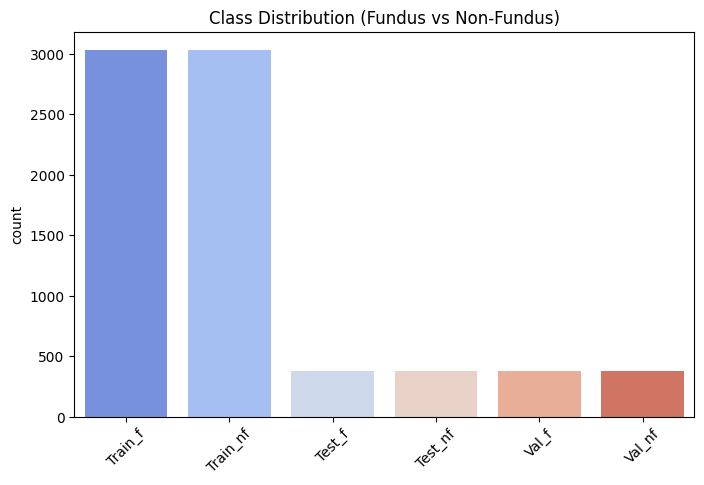

In [40]:
# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution (Fundus vs Non-Fundus)")
plt.xticks(rotation=45)
plt.show()

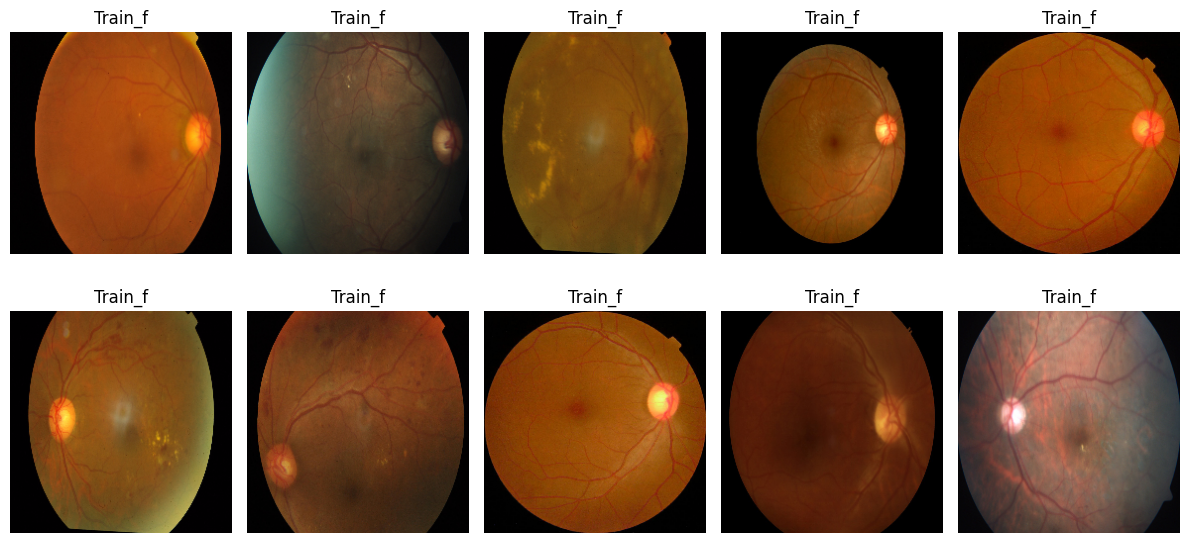

In [41]:
# Sample of the processed image
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(processed_data[i], cmap="gray")
    axes[i].set_title(labels[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

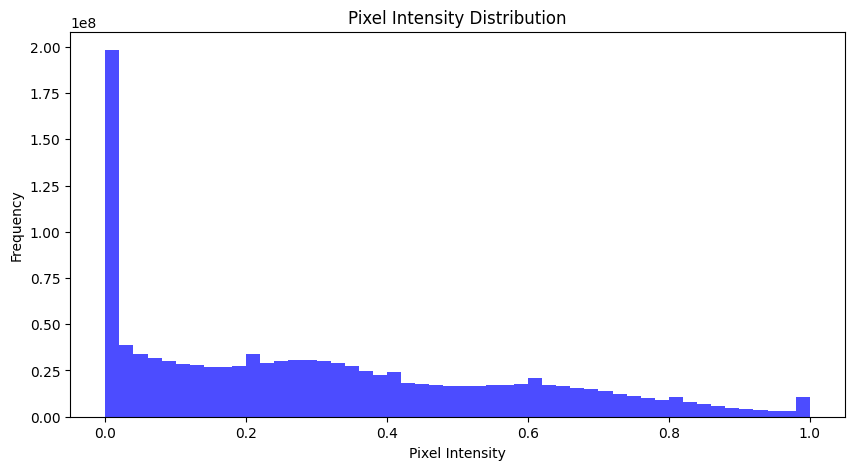

In [42]:
# pixel intensity distribution
plt.figure(figsize=(10, 5))
plt.hist(processed_data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

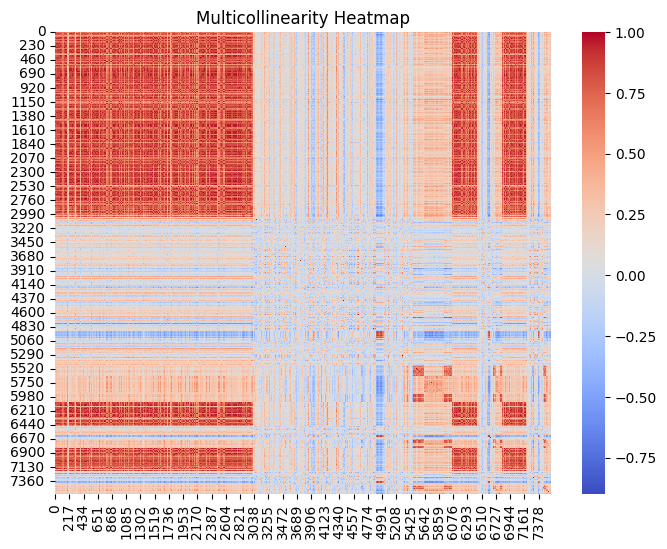

In [43]:
# Correlation hashmap (Multicorlinearity)

# Compute correlation matrix
image_flattened = processed_data.reshape(processed_data.shape[0], -1)
correlation_matrix = np.corrcoef(image_flattened)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Multicollinearity Heatmap")
plt.show()

In [16]:

import hashlib

# Define paths
base_path = "D:/Preprocessed_Data/"
dataset_folders = {
    "train": ["Train_f", "Train_nf"],
    "test": ["Test_f", "Test_nf"],
    "val": ["Val_f", "Val_nf"]
}

# Function to compute image hash
def compute_image_hash(img_path):
    with open(img_path, 'rb') as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    return img_hash

# Collect hashes
image_hashes = {
    "train": set(),
    "test": set(),
    "val": set()
}

# Check for duplicates
def collect_hashes(dataset_type):
    for folder in dataset_folders[dataset_type]:
        folder_path = os.path.join(base_path, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_hash = compute_image_hash(img_path)
            image_hashes[dataset_type].add(img_hash)

for set_type in image_hashes.keys():
    collect_hashes(set_type)

# Find intersections
train_test_overlap = image_hashes["train"].intersection(image_hashes["test"])
train_val_overlap = image_hashes["train"].intersection(image_hashes["val"])
test_val_overlap = image_hashes["test"].intersection(image_hashes["val"])

# Report results
print(f"Duplicate images between train and test: {len(train_test_overlap)}")
print(f"Duplicate images between train and val: {len(train_val_overlap)}")
print(f"Duplicate images between test and val: {len(test_val_overlap)}")


Duplicate images between train and test: 24
Duplicate images between train and val: 22
Duplicate images between test and val: 3


In [18]:
import shutil

# Folder to move duplicates
duplicate_folder = "D:/Removed_Duplicates/"
os.makedirs(duplicate_folder, exist_ok=True)

# Function to remove duplicate images
def remove_duplicates(overlap_set, src_folder):
    for folder in dataset_folders[src_folder]:
        folder_path = os.path.join(base_path, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_hash = compute_image_hash(img_path)
            if img_hash in overlap_set:
                dest = os.path.join(duplicate_folder, img_name)
                shutil.move(img_path, dest)
                print(f"Moved duplicate: {img_path} → {dest}")

# Move duplicates from test and val
remove_duplicates(train_test_overlap, "test")
remove_duplicates(train_val_overlap, "val")
remove_duplicates(test_val_overlap, "val")


Moved duplicate: D:/Preprocessed_Data/Test_f\e4e343eaae2a.png → D:/Removed_Duplicates/e4e343eaae2a.png
Moved duplicate: D:/Preprocessed_Data/Test_f\e740af6ac6ea.png → D:/Removed_Duplicates/e740af6ac6ea.png
Moved duplicate: D:/Preprocessed_Data/Test_f\e76a9cbb2a8c.png → D:/Removed_Duplicates/e76a9cbb2a8c.png
Moved duplicate: D:/Preprocessed_Data/Test_f\e7a7187066ad.png → D:/Removed_Duplicates/e7a7187066ad.png
Moved duplicate: D:/Preprocessed_Data/Test_f\ea05c22d92e9.png → D:/Removed_Duplicates/ea05c22d92e9.png
Moved duplicate: D:/Preprocessed_Data/Test_f\ea15a290eb96.png → D:/Removed_Duplicates/ea15a290eb96.png
Moved duplicate: D:/Preprocessed_Data/Test_f\ea9e0fb6fb0b.png → D:/Removed_Duplicates/ea9e0fb6fb0b.png
Moved duplicate: D:/Preprocessed_Data/Test_f\eadc57064154.png → D:/Removed_Duplicates/eadc57064154.png
Moved duplicate: D:/Preprocessed_Data/Test_f\ed3a0fc5b546.png → D:/Removed_Duplicates/ed3a0fc5b546.png
Moved duplicate: D:/Preprocessed_Data/Test_f\ee2c2a5f7d0e.png → D:/Remove

In [19]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Define paths
base_path = "D:/Preprocessed_Data/"
features_path = "D:/Features/"
model_save_path = "D:/Models/fundus_rf_model.pkl"

# Ensure directories exist
os.makedirs(features_path, exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Define categories (Fundus = 1, Non-Fundus = 0)
dataset_folders = {
    "train": [("Train_f", 1), ("Train_nf", 0)],
    "test": [("Test_f", 1), ("Test_nf", 0)],
    "val": [("Val_f", 1), ("Val_nf", 0)]
}
IMG_SIZE = (224, 224)

# Function to load images from folders
def load_images(dataset_type):
    images, labels = [], []
    for folder, label in dataset_folders[dataset_type]:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels)

# Load datasets directly
X_train, y_train = load_images("train")
X_test, y_test = load_images("test")
X_val, y_val = load_images("val")

print(f"Train: {len(X_train)}, Test: {len(X_test)}, Val: {len(X_val)} images loaded.")

# Pretrained models for feature extraction
models = {
    "ResNet50": (ResNet50(weights='imagenet', include_top=False, pooling='avg'), resnet_preprocess),
    "VGG16": (VGG16(weights='imagenet', include_top=False, pooling='avg'), vgg_preprocess),
    "EfficientNetB0": (EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'), efficientnet_preprocess)
}

# Feature extraction function
def extract_features(model, preprocess_func, data):
    data = preprocess_func(data)  # Ensure correct input format
    return model.predict(data, batch_size=32)

# Paths for saving features
feature_paths = {
    "train": os.path.join(features_path, "X_train_features.npy"),
    "test": os.path.join(features_path, "X_test_features.npy"),
    "val": os.path.join(features_path, "X_val_features.npy"),
}
label_paths = {
    "train": os.path.join(features_path, "y_train.npy"),
    "test": os.path.join(features_path, "y_test.npy"),
    "val": os.path.join(features_path, "y_val.npy"),
}

# Check if features are already saved
if all(os.path.exists(path) for path in feature_paths.values()):
    print("Loading saved features from D:/Features...")
    X_train_features = np.load(feature_paths["train"])
    X_test_features = np.load(feature_paths["test"])
    X_val_features = np.load(feature_paths["val"])
    y_train = np.load(label_paths["train"])
    y_test = np.load(label_paths["test"])
    y_val = np.load(label_paths["val"])
else:
    # Extract features for each dataset
    def extract_and_save(dataset_type, X, y):
        feature_sets = []
        for name, (model, preprocess_func) in models.items():
            print(f"Extracting {dataset_type} features using {name}...")
            features = extract_features(model, preprocess_func, X)
            feature_sets.append(features)
        
        # Combine features from all models
        X_features = np.concatenate(feature_sets, axis=1)

        # Save extracted features & labels
        np.save(feature_paths[dataset_type], X_features)
        np.save(label_paths[dataset_type], y)

    extract_and_save("train", X_train, y_train)
    extract_and_save("test", X_test, y_test)
    extract_and_save("val", X_val, y_val)

    print("Features saved successfully in D:/Features!")


Train: 6056, Test: 734, Val: 731 images loaded.
Extracting train features using ResNet50...
190/190 ━━━━━━━━━━━━━━━━━━━━ 178s 930ms/step
Extracting train features using VGG16...
190/190 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step
Extracting train features using EfficientNetB0...
190/190 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step
Extracting test features using ResNet50...
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 763ms/step
Extracting test features using VGG16...
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step
Extracting test features using EfficientNetB0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 812ms/step
Extracting val features using ResNet50...
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
Extracting val features using VGG16...
23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step
Extracting val features using EfficientNetB0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 679ms/step
Features saved successfully in D:/Features!


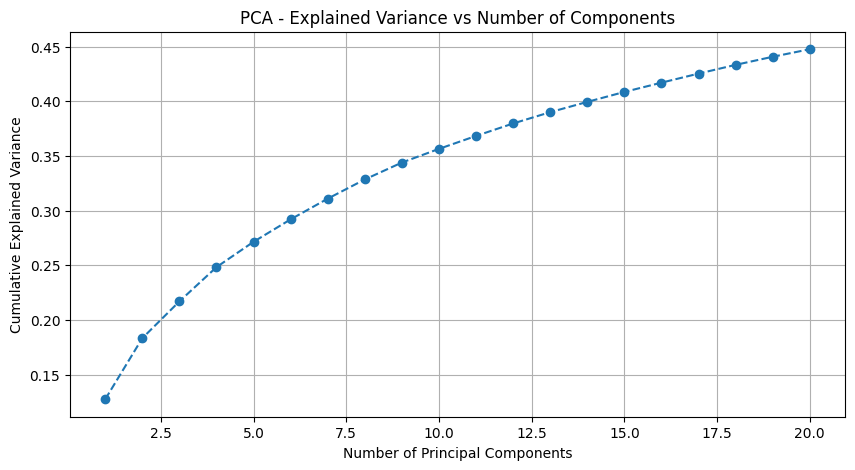

Explained variance by each component: [0.12752356 0.05583566 0.03366503 0.03130373 0.02317735 0.02053186
 0.01891877 0.01755663 0.01546534 0.01250333]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load extracted features
X_train_features = np.load("D:/Features/X_train_features.npy")

# Standardize the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_features)

# Apply PCA
pca = PCA(n_components=20)  # Start with 20 components
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs Number of Components")
plt.grid()
plt.show()

# Print explained variance ratio for the first few components
print("Explained variance by each component:", pca.explained_variance_ratio_[:10])


In [20]:
import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Paths
features_path = "D:/Features/"
model_save_path = "D:/Models/fundus_rf_best_model.pkl"

# Ensure model directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Load features and labels
train_features_path = os.path.join(features_path, "X_train_features.npy")
test_features_path = os.path.join(features_path, "X_test_features.npy")
val_features_path = os.path.join(features_path, "X_val_features.npy")
train_labels_path = os.path.join(features_path, "y_train.npy")
test_labels_path = os.path.join(features_path, "y_test.npy")
val_labels_path = os.path.join(features_path, "y_val.npy")

print("Loading extracted features and labels...")
X_train_features = np.load(train_features_path)
X_test_features = np.load(test_features_path)
X_val_features = np.load(val_features_path)
y_train = np.load(train_labels_path)
y_test = np.load(test_labels_path)
y_val = np.load(val_labels_path)

print(f"Training samples: {X_train_features.shape[0]}")
print(f"Validation samples: {X_val_features.shape[0]}")
print(f"Testing samples: {X_test_features.shape[0]}")

# Initialize Random Forest classifier with improved hyperparameters
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42
)

# Train the model
print("Training Random Forest model...")
rf.fit(X_train_features, y_train)

# Predictions on Training, Validation, and Test Sets
print("\nEvaluating model on training, validation, and test sets...")
y_train_pred = rf.predict(X_train_features)
y_val_pred = rf.predict(X_val_features)
y_test_pred = rf.predict(X_test_features)

# Compute Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n==== Model Performance ====")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Classification Reports
print("\n==== Classification Report: Training Data ====")
print(classification_report(y_train, y_train_pred))

print("\n==== Classification Report: Validation Data ====")
print(classification_report(y_val, y_val_pred))

print("\n==== Classification Report: Testing Data ====")
print(classification_report(y_test, y_test_pred))

# Save the trained model
with open(model_save_path, "wb") as f:
    pickle.dump(rf, f)

print(f"\nRandom Forest model saved at {model_save_path}")


Loading extracted features and labels...
Training samples: 6056
Validation samples: 731
Testing samples: 734
Training Random Forest model...

Evaluating model on training, validation, and test sets...

==== Model Performance ====
Training Accuracy: 1.0000
Validation Accuracy: 1.0000
Testing Accuracy: 1.0000

==== Classification Report: Training Data ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3028
           1       1.00      1.00      1.00      3028

    accuracy                           1.00      6056
   macro avg       1.00      1.00      1.00      6056
weighted avg       1.00      1.00      1.00      6056


==== Classification Report: Validation Data ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       377
           1       1.00      1.00      1.00       354

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00     

In [ ]:

# Feature Visualization using t-SNE
def visualize_features(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Class")
    plt.show()

# Visualizing training and test features
visualize_features(X_train_features, y_train, "t-SNE Visualization of Training Features")
visualize_features(X_test_features, y_test, "t-SNE Visualization of Test Features")

In [ ]:
import os
import cv2
import numpy as np
import pickle
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==== PATHS ====
base_path = "D:/Preprocessed_Data/"
features_path = "D:/Features/"
model_save_path = "D:/Models/fundus_rf_model.pkl"

# Ensure directories exist
os.makedirs(features_path, exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# ==== DATASET FOLDERS ====
dataset_folders = {
    "train": [("Train_f", 1), ("Train_nf", 0)],
    "test": [("Test_f", 1), ("Test_nf", 0)],
    "val": [("Val_f", 1), ("Val_nf", 0)]
}
IMG_SIZE = (224, 224)

# ==== FUNCTION TO LOAD IMAGES ====
def load_images(dataset_type):
    images, labels = [], []
    for folder, label in dataset_folders[dataset_type]:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels)

# Load datasets (No train-test split needed!)
X_train, y_train = load_images("train")
X_test, y_test = load_images("test")
X_val, y_val = load_images("val")

print(f"Train: {len(X_train)}, Test: {len(X_test)}, Val: {len(X_val)} images loaded.")

# ==== PRETRAINED MODELS ====
models = {
    "ResNet50": (ResNet50(weights='imagenet', include_top=False, pooling='avg'), resnet_preprocess),
    "VGG16": (VGG16(weights='imagenet', include_top=False, pooling='avg'), vgg_preprocess),
    "EfficientNetB0": (EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'), efficientnet_preprocess)
}

# ==== FEATURE EXTRACTION FUNCTION ====
def extract_features(model, preprocess_func, data):
    data = preprocess_func(data)  # Preprocess input for the specific model
    return model.predict(data, batch_size=32)

# Paths for saving features
feature_paths = {
    "train": os.path.join(features_path, "X_train_features.npy"),
    "test": os.path.join(features_path, "X_test_features.npy"),
    "val": os.path.join(features_path, "X_val_features.npy"),
}
label_paths = {
    "train": os.path.join(features_path, "y_train.npy"),
    "test": os.path.join(features_path, "y_test.npy"),
    "val": os.path.join(features_path, "y_val.npy"),
}

# ==== CHECK IF FEATURES ARE ALREADY SAVED ====
if all(os.path.exists(path) for path in feature_paths.values()):
    print("Loading saved features from D:/Features...")
    X_train_features = np.load(feature_paths["train"])
    X_test_features = np.load(feature_paths["test"])
    X_val_features = np.load(feature_paths["val"])
    y_train = np.load(label_paths["train"])
    y_test = np.load(label_paths["test"])
    y_val = np.load(label_paths["val"])
else:
    # Extract features for each dataset
    def extract_and_save(dataset_type, X, y):
        feature_sets = []
        for name, (model, preprocess_func) in models.items():
            print(f"Extracting {dataset_type} features using {name}...")
            features = extract_features(model, preprocess_func, X)
            feature_sets.append(features)
        
        # Combine features from all models
        X_features = np.concatenate(feature_sets, axis=1)

        # Save extracted features & labels
        np.save(feature_paths[dataset_type], X_features)
        np.save(label_paths[dataset_type], y)

    extract_and_save("train", X_train, y_train)
    extract_and_save("test", X_test, y_test)
    extract_and_save("val", X_val, y_val)

    print("Features saved successfully in D:/Features!")

# ==== LOAD EXTRACTED FEATURES ====
X_train_features = np.load(feature_paths["train"])
X_test_features = np.load(feature_paths["test"])
X_val_features = np.load(feature_paths["val"])
y_train = np.load(label_paths["train"])
y_test = np.load(label_paths["test"])
y_val = np.load(label_paths["val"])

# ==== TRAIN RANDOM FOREST CLASSIFIER ====
print("Training Random Forest model...")
rf = RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_split=5, 
                            min_samples_leaf=2, max_features="sqrt", random_state=42)
rf.fit(X_train_features, y_train)

# ==== EVALUATE MODEL ====
print("\nEvaluating model on training, validation, and test sets...")
y_train_pred = rf.predict(X_train_features)
y_val_pred = rf.predict(X_val_features)
y_test_pred = rf.predict(X_test_features)

# Compute Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n==== Model Performance ====")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Classification Reports
print("\n==== Classification Report: Training Data ====")
print(classification_report(y_train, y_train_pred))

print("\n==== Classification Report: Validation Data ====")
print(classification_report(y_val, y_val_pred))

print("\n==== Classification Report: Testing Data ====")
print(classification_report(y_test, y_test_pred))

# ==== SAVE TRAINED RANDOM FOREST MODEL ====
with open(model_save_path, "wb") as f:
    pickle.dump(rf, f)

print(f"\nRandom Forest model saved at {model_save_path}")
